In [1]:
#! pip install lightgbm
#! pip install xgboost
#! pip install pycaret

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE

import xgboost as xgb

import lightgbm as lgb
import pickle

from pycaret.classification import *
import base64
import itertools


# Implémentez un modèle de scoring

## Contexte
La société financière __Prêt à penser__ propose des crédits à la consommation aux personnes ayant peu d'historique de crédit. Aujourd'hui elle souhaite développer un modèle de scoring pour les aider à décider à accorder un prêt ou non à leur futur client. <br>
Aussi souhaite-t-elle développer en parallèle un dashboard qui permettra à leur collaborateur d'expliquer aux clients les raisons de leur choix. Ces derniers sont de plus en plus demandeur de transparence.

## Jeu de données
__Prêt à penser__ nous a mis à disposition un ensemble de jeu de données qui relatent des faits financières de plusieurs clients (montant des crédits précédents, leur nombre, leur état (en cours, défaut, completé etc) et des données indirectes (sex du client, conjoint, nombre d'enfants etc)

## Enjeux
À partir de ces données, nous allons développer un modèle classification qui sera mis en perspective à l'aide d'un dashboard qui permettra aux chargés de relation client d'expliquer aux clients les décisions émises quant à leur besoin de crédit.

## Table des matières

* [Chargement des données](#chap1)
* [Définition des fonctions](#chap2)
* [Nettoyages des données et feature engineering](#chap3)

    * [Section 1.1](#section_1_1)
    * [Section 1.2](sSection_1_2)
        * [Section 1.2.1](#section_1_2_1)
        * [Section 1.2.2](#section_1_2_2)
        * [Section 1.2.3](#section_1_2_3)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)

# Chargement des données <a class="anchor" id="chap1"></a>

In [3]:
# appTest = pd.read_csv("zip/application_test.csv")
appTrain = pd.read_csv("zip/application_train.csv")
# bureau = pd.read_csv("zip/bureau.csv")
# bureauBal = pd.read_csv("zip/bureau_balance.csv")
# creditCardBal = pd.read_csv("zip/credit_card_balance.csv")
homeCredit = pd.read_csv("zip/HomeCredit_columns_description.csv")
# installmentsP = pd.read_csv("zip/installments_payments.csv")
# POS_CASH_B = pd.read_csv("zip/POS_CASH_balance.csv")
# previous_Apps = pd.read_csv("zip/previous_application.csv")
# sample_sub = pd.read_csv("zip/sample_submission.csv")

# Définition des fonctions <a class="anchor" id="chap2"></a>

In [4]:
# Reduire la taille des données
def reduce_mem_usage(df):
   
    start_mem = df.memory_usage().sum() / 1024**2
    print('Taille du Dataframe avant traitement {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Taille du Dataframe après traitement: {:.2f} MB'.format(end_mem))
    print('Réduction de {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
def Description(Status=""):
    dire = homeCredit.loc[homeCredit["Row"]==Status,]["Description"]
    print(dire.values)
    return dire

In [6]:
def colNul(df, nulle = 0):
    print(df.loc[:,(df.isna().sum() == nulle).values])
    return list(df.loc[:,(df.isna().sum() == nulle).values].columns)

In [7]:
def extraireColonneInf(df, pourcentage = 1):
    
    save = (df.notna().sum(axis=0)/df.shape[0])
    save = save[save <= pourcentage]
    return list(save.index)

In [8]:
def removeCorrelation(corr, seuil):
    deja = []
    for i in corr.index:
        if i not in list(itertools.chain(*deja)):
#             print(i)
#             print(corr[(np.abs(corr[i]) >=0.8) & (corr[i].index !=i)].index)
            deja.append(list(corr[(corr[i] >=0.8) & (corr[i].index !=i)].index))
            #list(itertools.chain(*ls))
            
    return list(itertools.chain(*deja))

# Nettoyages des données et feature engineering <a class="anchor" id="chap3"></a>

In [9]:
# appTest = reduce_mem_usage(appTest) 
appTrain = reduce_mem_usage(appTrain)
# bureau = reduce_mem_usage(bureau) 
# bureauBal = reduce_mem_usage(bureauBal) 
# creditCardBal = reduce_mem_usage(creditCardBal) 
homeCredit = reduce_mem_usage(homeCredit) 
# installmentsP = reduce_mem_usage(installmentsP) 
# POS_CASH_B = reduce_mem_usage(POS_CASH_B) 
# previous_Apps = reduce_mem_usage(previous_Apps) 
# sample_sub = reduce_mem_usage(sample_sub) 

Taille du Dataframe avant traitement 286.23 MB
Taille du Dataframe après traitement: 59.54 MB
Réduction de 79.2%
Taille du Dataframe avant traitement 0.01 MB
Taille du Dataframe après traitement: 0.01 MB
Réduction de -55.3%


Nous réduisons la taille du jeu de données dans la mémoire.

In [10]:
# Train_num = appTrain.select_dtypes(exclude=['category'])
# Train_cat = appTrain.select_dtypes(include=['category'])

In [11]:
appTrain.shape

(307511, 122)

In [12]:
# test = (appTrain.notna().sum(axis=0)/appTrain.shape[0])
# list(test[test <=0.8].index)

In [13]:
appTrain.isna().sum(axis=0).sum()/(appTrain.shape[0]*appTrain.shape[1])

0.24395941907129431

Le dataset contient 24% de Nan

In [14]:
# appTrain['AMT_REQ_CREDIT_BUREAU_DAY'].describe()

In [15]:
colonne = extraireColonneInf(appTrain,0.8)

In [16]:
appTrainC = appTrain.drop(extraireColonneInf(appTrain,0.8), axis=1).copy()

In [17]:
appTrainC

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262939,0.139404,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622070,NaN,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.556152,0.729492,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008018,-19005,-3039,-9832.0,-2437,1,1,0,1,0,0,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650391,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028656,-19932,-3038,-4312.0,-3458,1,1,0,1,0,0,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322754,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032562,-9327,-236,-8456.0,-1982,1,1,0,1,0,0,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.681641,NaN,0.0,0.0,0.0,0.0,-273.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025162,-20775,365243,-4388.0,-4090,1,0,0,1,1,0,1.0,2,2,MONDAY,8,0,0,0,0,0,0,XNA,0.115967,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,N

On supprime les colonnes qui ont plus de 20% de NAN

In [18]:
appTrainC.isna().sum(axis=0).sum()/(appTrainC.shape[0]*appTrainC.shape[1])

0.01429072636606676

Il ne reste plus que 1.4% de Nan

In [19]:
# des = Description('AMT_REQ')

In [20]:
# des

In [21]:
appTrainC.drop(appTrainC.columns[appTrainC.columns.str.contains('AMT_REQ')], axis=1, inplace=True)

In [22]:
appTrainC.drop(appTrainC.columns[appTrainC.columns.str.contains('APPR')], axis=1, inplace=True)

In [23]:
appTrainC

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,0,0,0,0,0,0,Business Entity Type 3,0.262939,0.139404,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,0,0,0,0,0,0,School,0.622070,NaN,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,0,0,0,0,0,0,Government,0.556152,0.729492,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008018,-19005,-3039,-9832.0,-2437,1,1,0,1,0,0,2.0,2,2,0,0,0,0,0,0,Business Entity Type 3,0.650391,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028656,-19932,-3038,-4312.0,-3458,1,1,0,1,0,0,1.0,2,2,0,0,0,0,1,1,Religion,0.322754,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032562,-9327,-236,-8456.0,-1982,1,1,0,1,0,0,1.0,1,1,0,0,0,0,0,0,Services,0.681641,NaN,0.0,0.0,0.0,0.0,-273.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025162,-20775,365243,-4388.0,-4090,1,0,0,1,1,0,1.0,2,2,0,0,0,0,0,0,XNA,0.115967,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,0.005001,-14966,-7921,-6736.0,-5150,1,1,0,1,0,1,1.0,3,3,0,0,0,0,1,1,School,0.535645,0.218872,6.0,0.0,6.0,0.0,-1909.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005314,-11961,-4786,

In [24]:
#test = Description('LIVE_CITY_NOT_WORK_CITY')

In [25]:
#test[test.index.values[0]]

In [26]:
# appTrainC.columns[appTrainC.columns.str.contains('NOT')]

In [27]:
# appTrainC['LIVE_REGION_NOT_WORK_REGION'].describe()

In [28]:
# appTrainC.drop(appTrainC.columns[appTrainC.columns.str.contains('NOT')], axis=1, inplace=True)

In [29]:
#Description('NAME_TYPE_SUITE')

In [30]:
# colonne = ['DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT_W_CITY', 
#            'REGION_RATING_CLIENT', 'NAME_TYPE_SUITE', 'DAYS_LAST_PHONE_CHANGE',
#           'DAYS_LAST_PHONE_CHANGE']

In [31]:
# appTrainC.drop(colonne, axis=1, inplace=True)

In [32]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 64 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SK_ID_CURR                   307511 non-null  int32   
 1   TARGET                       307511 non-null  int8    
 2   NAME_CONTRACT_TYPE           307511 non-null  category
 3   CODE_GENDER                  307511 non-null  category
 4   FLAG_OWN_CAR                 307511 non-null  category
 5   FLAG_OWN_REALTY              307511 non-null  category
 6   CNT_CHILDREN                 307511 non-null  int8    
 7   AMT_INCOME_TOTAL             307511 non-null  float32 
 8   AMT_CREDIT                   307511 non-null  float32 
 9   AMT_ANNUITY                  307499 non-null  float32 
 10  AMT_GOODS_PRICE              307233 non-null  float32 
 11  NAME_TYPE_SUITE              306219 non-null  category
 12  NAME_INCOME_TYPE             307511 non-null

In [33]:
# test = Description('ORGANIZATION_TYPE')

In [34]:
# test[test.index.values[0]]

In [35]:
#appTrainC.drop('NAME_TYPE_SUITE', axis=1, inplace=True)
#appTrainC.drop(['DAYS_LAST_PHONE_CHANGE'], axis=1, inplace=True)

In [36]:
#appTrainC.loc[:,'FLAG_DOCUMENT_2': 'FLAG_DOCUMENT_21'].sum(axis=1).describe()

In [37]:
#appTrainC.drop(list(appTrainC.loc[:,'FLAG_DOCUMENT_2': 'FLAG_DOCUMENT_21'].columns), axis=1, inplace=True)

La variation des variables FLAG_DOCUMENT est faible. Nous allons les supprimer

In [38]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 64 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SK_ID_CURR                   307511 non-null  int32   
 1   TARGET                       307511 non-null  int8    
 2   NAME_CONTRACT_TYPE           307511 non-null  category
 3   CODE_GENDER                  307511 non-null  category
 4   FLAG_OWN_CAR                 307511 non-null  category
 5   FLAG_OWN_REALTY              307511 non-null  category
 6   CNT_CHILDREN                 307511 non-null  int8    
 7   AMT_INCOME_TOTAL             307511 non-null  float32 
 8   AMT_CREDIT                   307511 non-null  float32 
 9   AMT_ANNUITY                  307499 non-null  float32 
 10  AMT_GOODS_PRICE              307233 non-null  float32 
 11  NAME_TYPE_SUITE              306219 non-null  category
 12  NAME_INCOME_TYPE             307511 non-null

In [39]:
appTrainC.columns[appTrainC.columns.str.contains('FLAG')]

Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'],
      dtype='object')

In [40]:
appTrainC['EXT_SOURCE_3'].describe()

count    246546.000000
mean               NaN
std           0.000000
min           0.000527
25%           0.370605
50%           0.535156
75%           0.668945
max           0.895996
Name: EXT_SOURCE_3, dtype: float64

In [41]:
valeur = appTrainC.loc[appTrainC['EXT_SOURCE_3'].notna(),'EXT_SOURCE_3'].astype(np.float32).mean()

In [42]:
appTrainC['EXT_SOURCE_3'].fillna(valeur, inplace=True)

In [43]:
valeur = appTrainC.loc[appTrainC['EXT_SOURCE_2'].notna(),'EXT_SOURCE_2'].astype(np.float32).mean()

In [44]:
appTrainC['EXT_SOURCE_2'].fillna(valeur, inplace=True)

In [45]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 64 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SK_ID_CURR                   307511 non-null  int32   
 1   TARGET                       307511 non-null  int8    
 2   NAME_CONTRACT_TYPE           307511 non-null  category
 3   CODE_GENDER                  307511 non-null  category
 4   FLAG_OWN_CAR                 307511 non-null  category
 5   FLAG_OWN_REALTY              307511 non-null  category
 6   CNT_CHILDREN                 307511 non-null  int8    
 7   AMT_INCOME_TOTAL             307511 non-null  float32 
 8   AMT_CREDIT                   307511 non-null  float32 
 9   AMT_ANNUITY                  307499 non-null  float32 
 10  AMT_GOODS_PRICE              307233 non-null  float32 
 11  NAME_TYPE_SUITE              306219 non-null  category
 12  NAME_INCOME_TYPE             307511 non-null

In [46]:
#appTrainC['AMT_ANNUITY'].fillna(appTrainC['AMT_ANNUITY'].mean(), inplace=True)
appTrainC = appTrainC[appTrainC["AMT_ANNUITY"].notna()]

In [47]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307499 entries, 0 to 307510
Data columns (total 64 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SK_ID_CURR                   307499 non-null  int32   
 1   TARGET                       307499 non-null  int8    
 2   NAME_CONTRACT_TYPE           307499 non-null  category
 3   CODE_GENDER                  307499 non-null  category
 4   FLAG_OWN_CAR                 307499 non-null  category
 5   FLAG_OWN_REALTY              307499 non-null  category
 6   CNT_CHILDREN                 307499 non-null  int8    
 7   AMT_INCOME_TOTAL             307499 non-null  float32 
 8   AMT_CREDIT                   307499 non-null  float32 
 9   AMT_ANNUITY                  307499 non-null  float32 
 10  AMT_GOODS_PRICE              307221 non-null  float32 
 11  NAME_TYPE_SUITE              306207 non-null  category
 12  NAME_INCOME_TYPE             307499 non-null

In [48]:
# appTrainC.drop(list(appTrainC.columns[appTrainC.columns.str.contains('SOCIAL')]), axis=1, inplace=True)

In [49]:
# appTrainC.info()

In [50]:
#appTrainC['AMT_GOODS_PRICE'].mean()
appTrainC.loc[appTrain['AMT_GOODS_PRICE'].isna(), 'AMT_GOODS_PRICE'] = appTrain.loc[appTrain['AMT_GOODS_PRICE'].isna(),"AMT_CREDIT"]

In [51]:
appTrainC['CNT_FAM_MEMBERS'].fillna(appTrainC['CNT_FAM_MEMBERS'].astype(np.float32).mean(), inplace=True)

In [52]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307499 entries, 0 to 307510
Data columns (total 64 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SK_ID_CURR                   307499 non-null  int32   
 1   TARGET                       307499 non-null  int8    
 2   NAME_CONTRACT_TYPE           307499 non-null  category
 3   CODE_GENDER                  307499 non-null  category
 4   FLAG_OWN_CAR                 307499 non-null  category
 5   FLAG_OWN_REALTY              307499 non-null  category
 6   CNT_CHILDREN                 307499 non-null  int8    
 7   AMT_INCOME_TOTAL             307499 non-null  float32 
 8   AMT_CREDIT                   307499 non-null  float32 
 9   AMT_ANNUITY                  307499 non-null  float32 
 10  AMT_GOODS_PRICE              307499 non-null  float32 
 11  NAME_TYPE_SUITE              306207 non-null  category
 12  NAME_INCOME_TYPE             307499 non-null

In [53]:
appTrainC.loc[appTrainC["DAYS_EMPLOYED"]==365243, "DAYS_EMPLOYED"] = appTrainC.loc[appTrainC["DAYS_EMPLOYED"]!=365243, "DAYS_EMPLOYED"].mean()

365243 = XNA = NAN donc nous les supprimons

In [54]:
# appTrainC["AMT_INCOME_TOTAL"].describe()

In [55]:
# appTrainC = appTrainC[appTrainC["AMT_INCOME_TOTAL"] < appTrainC["AMT_INCOME_TOTAL"].max()]

Nous supprimons le outlier maximal du feature "AMT_INCOME_TOTAL"

## 2 nouveaux features


In [56]:
appTrainC["credSURrevenu"] = appTrainC["AMT_CREDIT"]/appTrainC["AMT_INCOME_TOTAL"]
appTrainC["annuitySURrevenu"] = appTrainC["AMT_ANNUITY"]/appTrainC["AMT_INCOME_TOTAL"]

Nous avons créé deux nouvelles features pour évaluer combien pèse le crédit sur les révenus du profil aussi bien le crédit total que les mensualités

In [57]:
appTrainC.shape

(307499, 66)

In [58]:
# appTrainC.dropna(inplace=True)

In [59]:
# appTrainC.shape

# Analyse univariée

In [60]:
appTrainC["TARGET"].value_counts()

0    282674
1     24825
Name: TARGET, dtype: int64

In [61]:
appTrainC["TARGET"].value_counts(normalize=True)

0    0.919268
1    0.080732
Name: TARGET, dtype: float64

92% des prêts sont accordés ne débouchent pas sur un défaut de paiement ou dis autrement 8% des prêts font un défaut.

In [62]:
appTrainC["CODE_GENDER"].value_counts(normalize=True)

F      0.658344
M      0.341643
XNA    0.000013
Name: CODE_GENDER, dtype: float64

In [63]:
appTrainC.shape

(307499, 66)

In [64]:
appTrainC = appTrainC[appTrainC["CODE_GENDER"].isin(["F", "M"])]

In [65]:
appTrainC["CODE_GENDER"]=appTrainC["CODE_GENDER"].astype('object')

Nous avons supprimé les profils avec le CODE_GENDER XNA (non communiqué) qui représente 0.000013% des données.
Aussi pouvons nous voir que les profils féminins représentent 66% des données et ceux masculins 34%

In [66]:
appTrainC.groupby(by="CODE_GENDER")["AMT_INCOME_TOTAL"].mean()

CODE_GENDER
F    156030.875000
M    193397.203125
Name: AMT_INCOME_TOTAL, dtype: float32

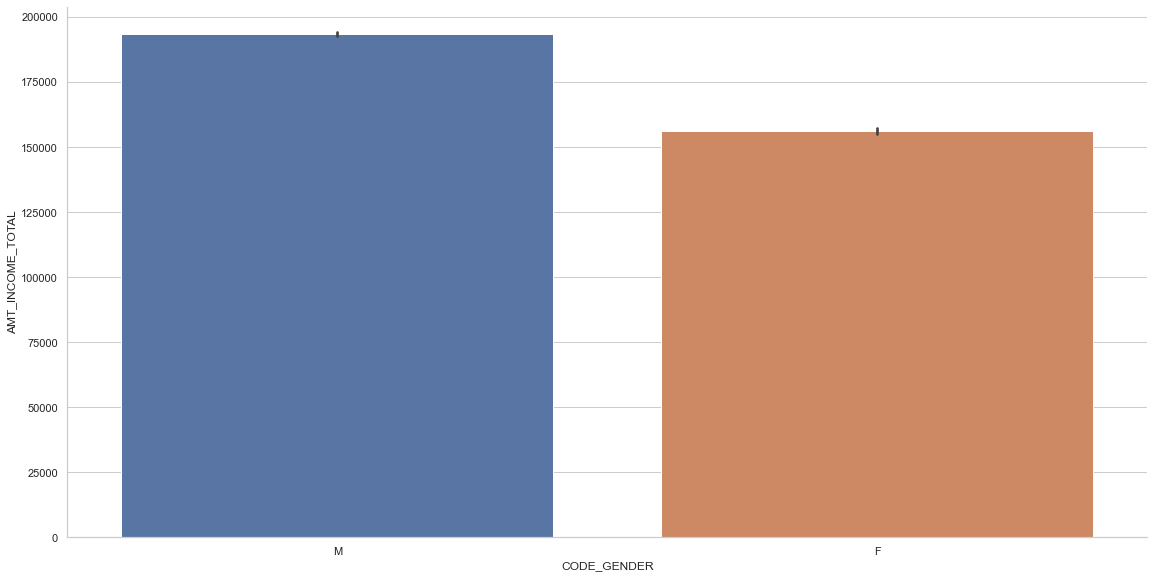

In [67]:

sns.catplot(x="CODE_GENDER", y="AMT_INCOME_TOTAL",kind="bar", height=8, aspect=2, data=appTrainC)


Le revenu des profils masculins est sensiblement plus important que les profils féminins

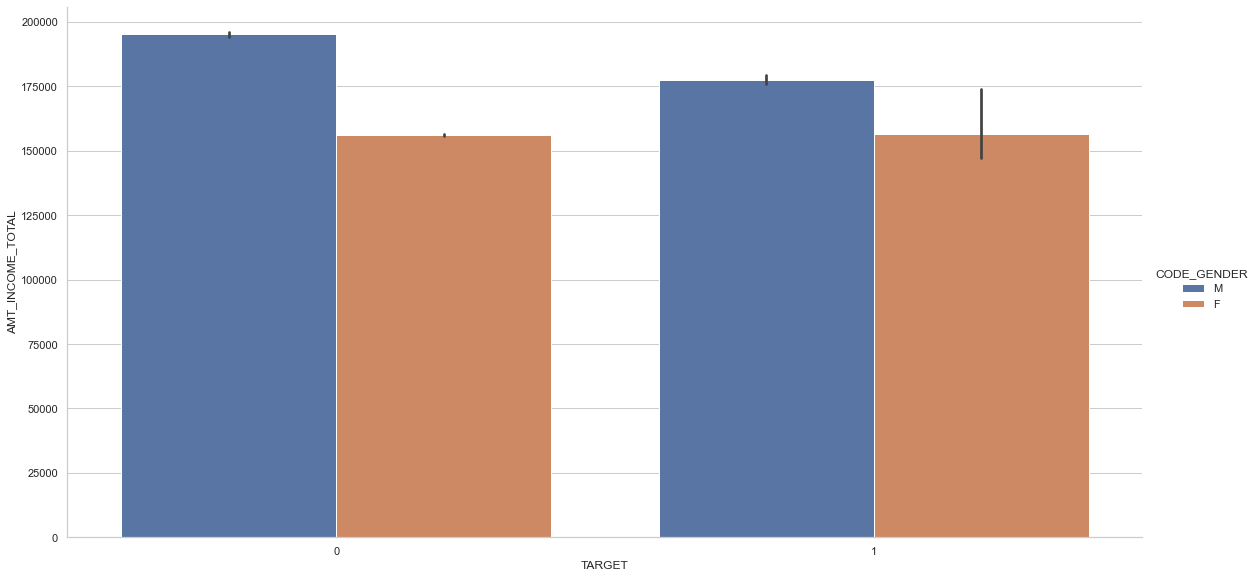

In [68]:
sns.catplot(x="TARGET", y="AMT_INCOME_TOTAL",kind="bar", hue="CODE_GENDER", height=8, aspect=2,data=appTrainC)

Les profils masculins en défaut de paiment gagnent en moyenne moins que les profils qui ne font pas de défaut de paiment. En revanche ce n'est pas le cas pour les profils féminins. Au contraire même. Les profils féminins en défaut de paiment ont des revenus légèrement supérieurs. <br>
Qu'est-ce qui implique alors le défaut de paiment si le salaire n'est pas un facteur important ?

In [69]:
appTrainC[appTrainC["TARGET"]==1]["CODE_GENDER"].value_counts()/appTrainC["CODE_GENDER"].value_counts()

F    0.069996
M    0.101423
Name: CODE_GENDER, dtype: float64

Les profils féminins sont certes plus important au sein du dataset, mais ramener à leur proportion, 7% des profils féminins font un défaut de paiment tandis que les profils masculins en défaut de paiment concernent 10%

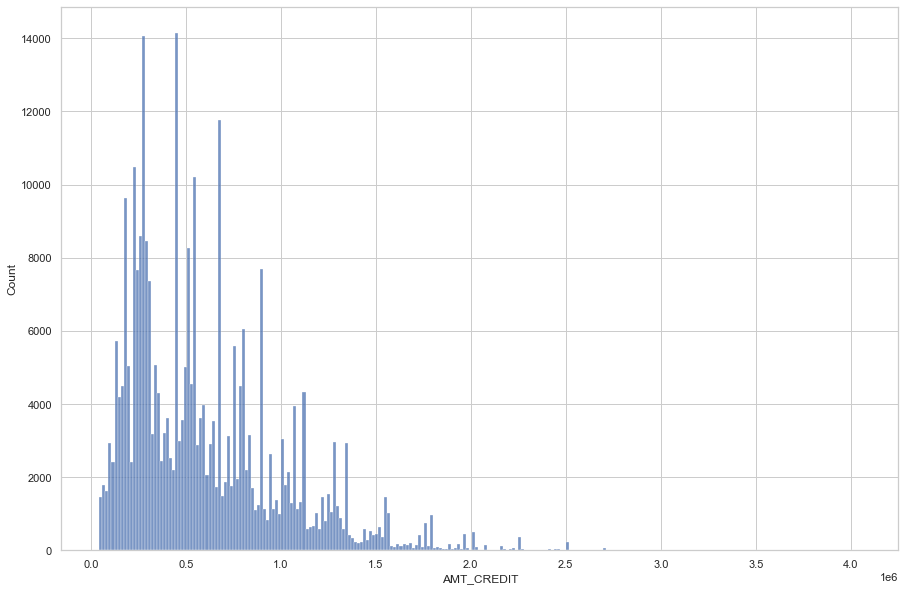

In [70]:
plt.figure(figsize=(15,10))
sns.histplot(data=appTrainC, x="AMT_CREDIT")
plt.show()

In [71]:
appTrainC["AMT_CREDIT"].mode()

0    450000.0
dtype: float32

Le mode des crédits est de 450000 (dollars)

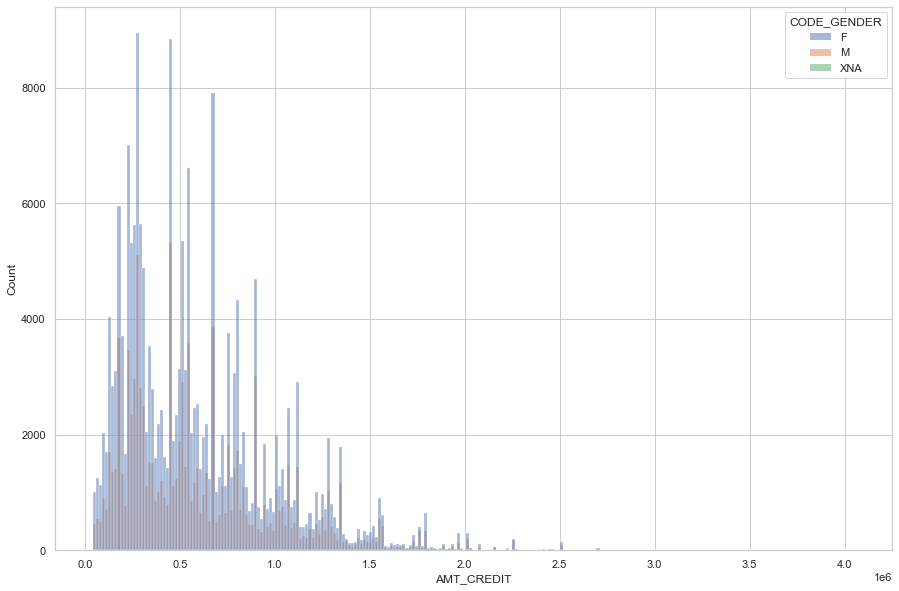

In [72]:
plt.figure(figsize=(15,10))
sns.histplot(data=appTrain, x="AMT_CREDIT", hue='CODE_GENDER')
plt.show()

Les F et M ont le même mode

In [73]:
print(pd.crosstab(appTrainC['NAME_CONTRACT_TYPE'], appTrainC['TARGET'], margins = True))

TARGET                   0      1     All
NAME_CONTRACT_TYPE                       
Cash loans          254999  23221  278220
Revolving loans      27671   1604   29275
All                 282670  24825  307495


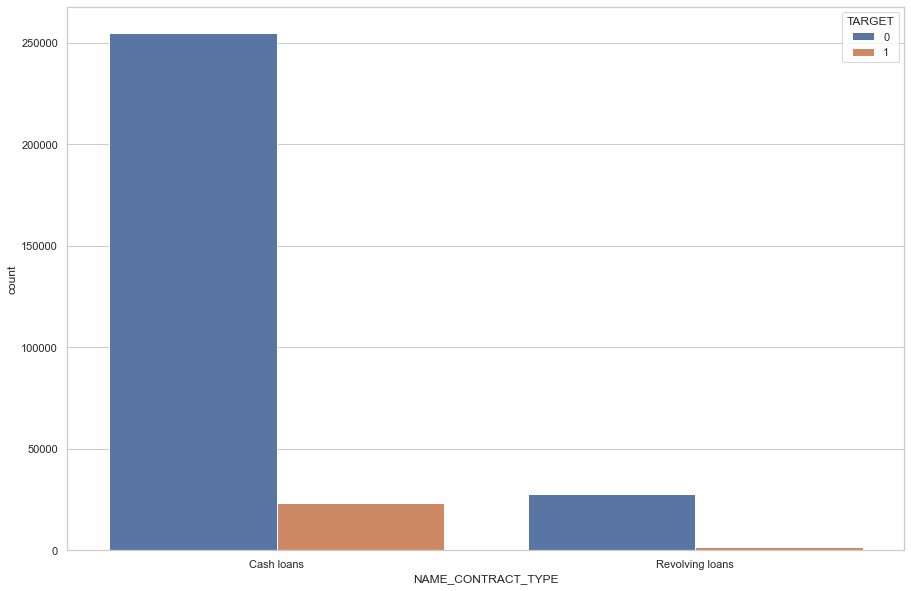

In [74]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x="NAME_CONTRACT_TYPE", hue="TARGET", data=appTrain)

In [75]:
pd.crosstab(appTrainC['NAME_CONTRACT_TYPE'], appTrainC['TARGET'], margins = True).loc["Cash loans"]

TARGET
0      254999
1       23221
All    278220
Name: Cash loans, dtype: int64

In [76]:
pd.crosstab(appTrainC['NAME_CONTRACT_TYPE'], appTrainC['TARGET'], margins = True).loc["Cash loans"]/278232

TARGET
0      0.916498
1      0.083459
All    0.999957
Name: Cash loans, dtype: float64

In [77]:
pd.crosstab(appTrainC['NAME_CONTRACT_TYPE'], appTrainC['TARGET'], margins = True).loc["Revolving loans"]

TARGET
0      27671
1       1604
All    29275
Name: Revolving loans, dtype: int64

In [78]:
pd.crosstab(appTrainC['NAME_CONTRACT_TYPE'], appTrainC['TARGET'], margins = True).loc["Revolving loans"]/29275

TARGET
0      0.945209
1      0.054791
All    1.000000
Name: Revolving loans, dtype: float64

Les contrats de type Cash Loans sont de très loin les plus demandés et c'est également sur ces types de contrat (en propotion) qu'il y a le plus de défaut de paiment.

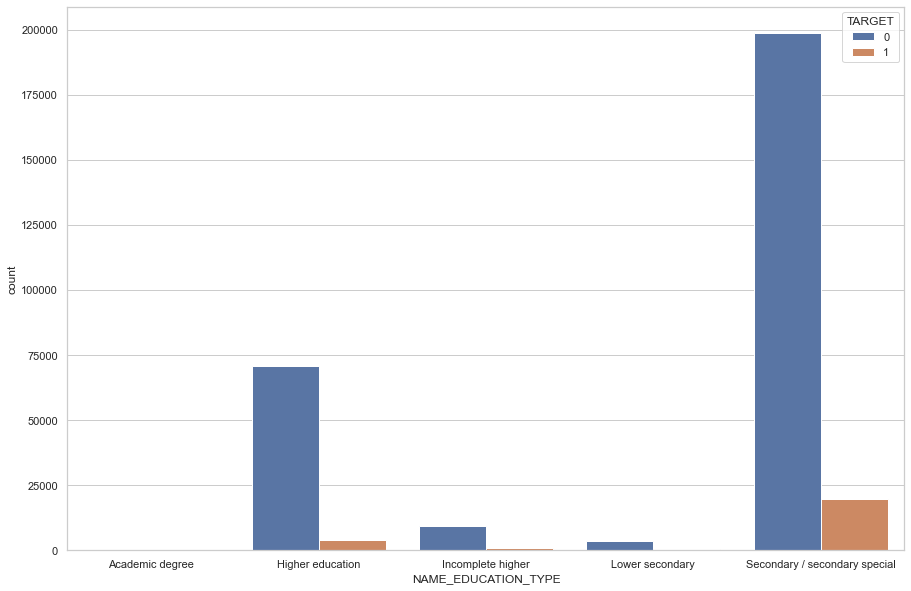

In [79]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x="NAME_EDUCATION_TYPE", hue="TARGET", data=appTrainC)

In [80]:
print(pd.crosstab(appTrain['NAME_EDUCATION_TYPE'], appTrain['TARGET'], margins = True))

TARGET                              0      1     All
NAME_EDUCATION_TYPE                                 
Academic degree                   161      3     164
Higher education                70854   4009   74863
Incomplete higher                9405    872   10277
Lower secondary                  3399    417    3816
Secondary / secondary special  198867  19524  218391
All                            282686  24825  307511


In [81]:
educ = pd.crosstab(appTrain['NAME_EDUCATION_TYPE'], appTrain['TARGET'], margins = True)

In [82]:
educ.iloc[0]/164

TARGET
0      0.981707
1      0.018293
All    1.000000
Name: Academic degree, dtype: float64

In [83]:
educ.iloc[1]/74863

TARGET
0      0.946449
1      0.053551
All    1.000000
Name: Higher education, dtype: float64

In [84]:
educ.iloc[2]/10277

TARGET
0      0.91515
1      0.08485
All    1.00000
Name: Incomplete higher, dtype: float64

In [85]:
educ.iloc[3]/3816

TARGET
0      0.890723
1      0.109277
All    1.000000
Name: Lower secondary, dtype: float64

In [86]:
educ.iloc[4]/218391

TARGET
0      0.910601
1      0.089399
All    1.000000
Name: Secondary / secondary special, dtype: float64

La classe __Lower secondary__ est plus susceptible d'avoir un défaut de paiment et les profils de la __Academic degree__ ont moins de defaut de paiment que les autres profils.

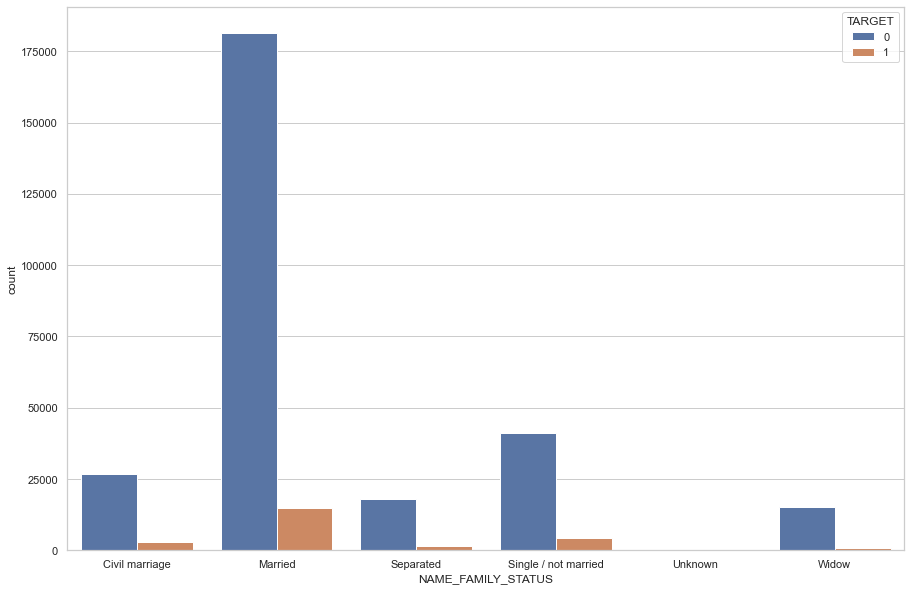

In [87]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x='NAME_FAMILY_STATUS', hue="TARGET", data=appTrainC)

In [88]:
familyStatus = pd.crosstab(appTrainC['NAME_FAMILY_STATUS'], appTrainC['TARGET'], margins = True)

In [89]:
familyStatus

TARGET,0,1,All
NAME_FAMILY_STATUS,,,
Civil marriage,26811,2961,29772
Married,181572,14850,196422
Separated,18150,1620,19770
Single / not married,40984,4457,45441
Unknown,2,0,2
Widow,15151,937,16088
All,282670,24825,307495


In [90]:
for i, ind in enumerate(familyStatus.index):
    print(ind)
    print(familyStatus.loc[ind]/familyStatus['All'].values[i])

Civil marriage
TARGET
0      0.900544
1      0.099456
All    1.000000
Name: Civil marriage, dtype: float64
Married
TARGET
0      0.924397
1      0.075603
All    1.000000
Name: Married, dtype: float64
Separated
TARGET
0      0.918058
1      0.081942
All    1.000000
Name: Separated, dtype: float64
Single / not married
TARGET
0      0.901917
1      0.098083
All    1.000000
Name: Single / not married, dtype: float64
Unknown
TARGET
0      1.0
1      0.0
All    1.0
Name: Unknown, dtype: float64
Widow
TARGET
0      0.941758
1      0.058242
All    1.000000
Name: Widow, dtype: float64
All
TARGET
0      0.919267
1      0.080733
All    1.000000
Name: All, dtype: float64


Les personnes seules sont plus susceptibles de faire un défaut.

In [91]:
appTrainC.groupby(by="TARGET")["REGION_POPULATION_RELATIVE"].mean()

TARGET
0    0.021027
1    0.019135
Name: REGION_POPULATION_RELATIVE, dtype: float16

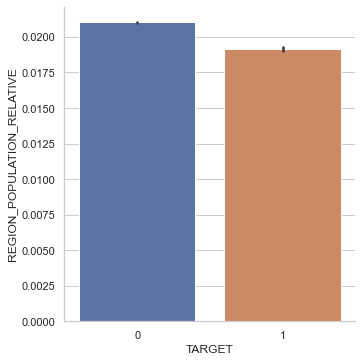

In [92]:
sns.catplot(x="TARGET", y="REGION_POPULATION_RELATIVE",kind="bar", data=appTrainC)

Les profils qui font défaut de paiment vivent dans des lieux moins peuplés.

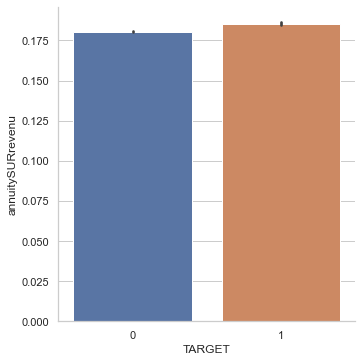

In [93]:
sns.catplot(x="TARGET", y="annuitySURrevenu",kind="bar", data=appTrainC)

Les mensualités pésent davantage sur les profils qui font défaut, mais ce n'est pas significatif.

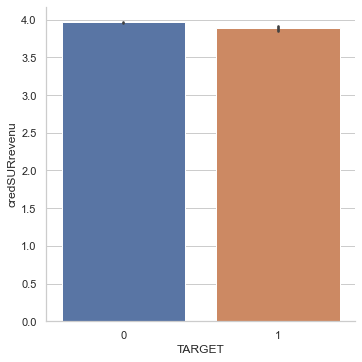

In [94]:
sns.catplot(x="TARGET", y="credSURrevenu",kind="bar", data=appTrainC)

Le poid du crédit sur le revenu total est plus ou moins équivalent sur les deux profils

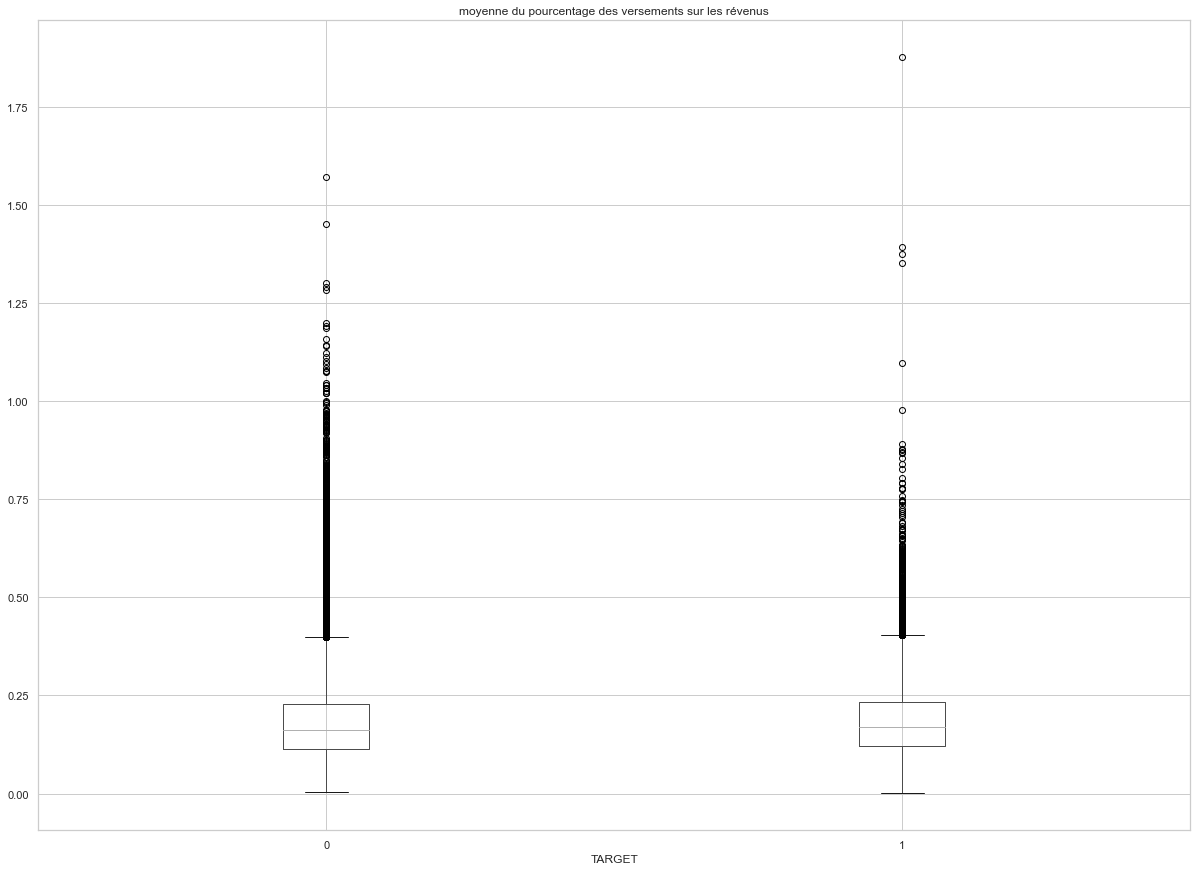

In [95]:
appTrainC.boxplot(column = ['annuitySURrevenu'], by = 'TARGET', figsize=(20,15))
plt.title('moyenne du pourcentage des versements sur les révenus')
plt.suptitle('')
plt.show()

Les deux profils (0 et 1) ont plus ou moins la même distribution avec un extremum chez 1, avec une mensualité qui pèse presque 2 fois ses revenus

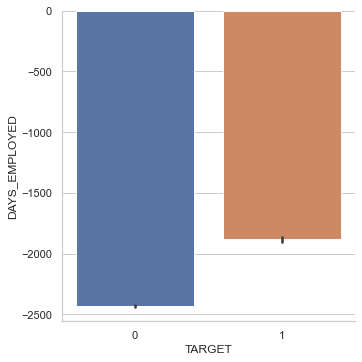

In [96]:
sns.catplot(x="TARGET", y="DAYS_EMPLOYED",kind="bar", data=appTrainC)

Nous constatons qu'il y a correlation entre le nombre de jour de salariat et le défaut de paiment.

In [97]:
appTrainC.groupby(by="TARGET")["CNT_FAM_MEMBERS"].mean()

TARGET
0    2.150391
1    2.181641
Name: CNT_FAM_MEMBERS, dtype: float16

<AxesSubplot:xlabel='TARGET'>

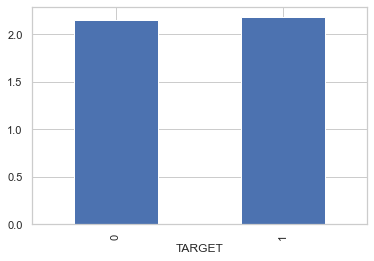

In [98]:
appTrainC.groupby(by="TARGET")["CNT_FAM_MEMBERS"].mean().plot.bar()

La taille des familles des deux profils est plus ou moins équivalente

In [99]:
house = pd.crosstab(appTrainC['NAME_HOUSING_TYPE'], appTrainC['TARGET'], margins = True)

In [100]:
house

TARGET,0,1,All
NAME_HOUSING_TYPE,,,
Co-op apartment,1033,89,1122
House / apartment,251583,21272,272855
Municipal apartment,10226,955,11181
Office apartment,2445,172,2617
Rented apartment,4279,601,4880
With parents,13104,1736,14840
All,282670,24825,307495


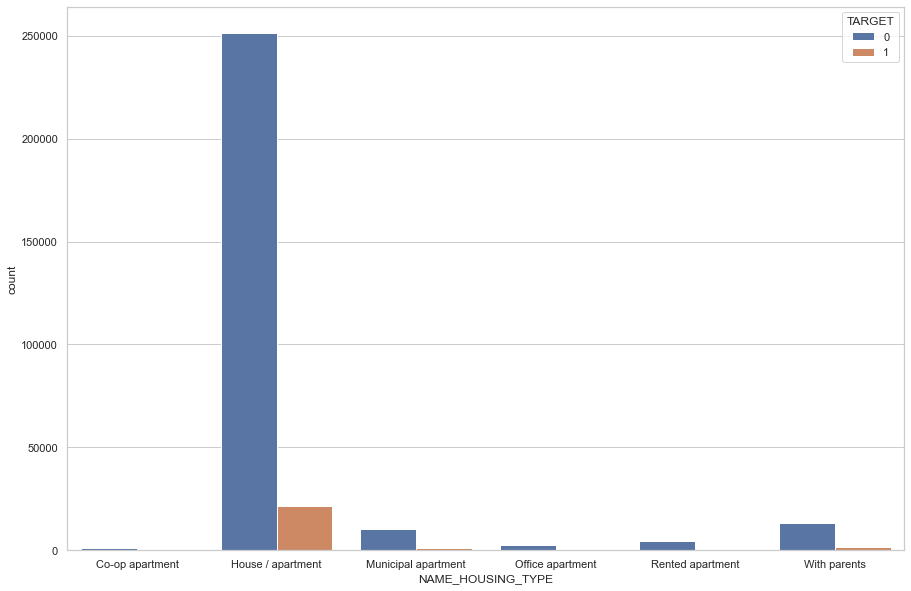

In [101]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x="NAME_HOUSING_TYPE", hue="TARGET", data=appTrainC)

In [102]:
for i, ind in enumerate(house.index):
    print(ind)
    print(house.loc[ind]/house['All'].values[i])

Co-op apartment
TARGET
0      0.920677
1      0.079323
All    1.000000
Name: Co-op apartment, dtype: float64
House / apartment
TARGET
0      0.922039
1      0.077961
All    1.000000
Name: House / apartment, dtype: float64
Municipal apartment
TARGET
0      0.914587
1      0.085413
All    1.000000
Name: Municipal apartment, dtype: float64
Office apartment
TARGET
0      0.934276
1      0.065724
All    1.000000
Name: Office apartment, dtype: float64
Rented apartment
TARGET
0      0.876844
1      0.123156
All    1.000000
Name: Rented apartment, dtype: float64
With parents
TARGET
0      0.883019
1      0.116981
All    1.000000
Name: With parents, dtype: float64
All
TARGET
0      0.919267
1      0.080733
All    1.000000
Name: All, dtype: float64


Les profils qui louent des appartements ont plus de chance de faire défaut.

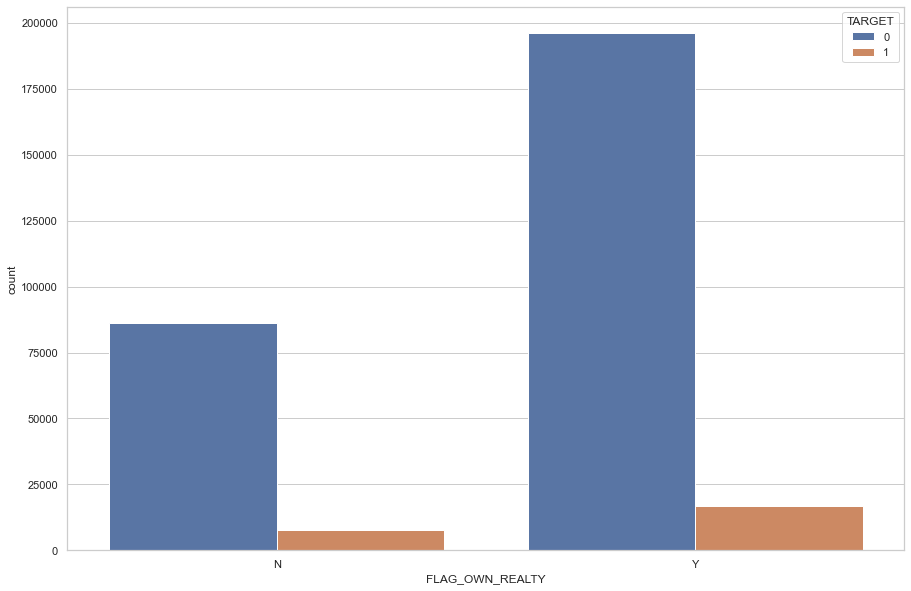

In [103]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x="FLAG_OWN_REALTY", hue="TARGET", data=appTrainC)

In [104]:
test = pd.crosstab(appTrainC["FLAG_OWN_REALTY"], appTrainC['TARGET'], margins = True)
test

TARGET,0,1,All
FLAG_OWN_REALTY,,,
N,86348,7842,94190
Y,196322,16983,213305
All,282670,24825,307495


In [105]:
for i, ind in enumerate(test.index):
    print(ind)
    print(test.loc[ind]/test['All'].values[i])

N
TARGET
0      0.916743
1      0.083257
All    1.000000
Name: N, dtype: float64
Y
TARGET
0      0.920382
1      0.079618
All    1.000000
Name: Y, dtype: float64
All
TARGET
0      0.919267
1      0.080733
All    1.000000
Name: All, dtype: float64


La possession d'un habitat n'influe pas sur le défaut

# Analyse bivariée

In [106]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307495 entries, 0 to 307510
Data columns (total 66 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SK_ID_CURR                   307495 non-null  int32   
 1   TARGET                       307495 non-null  int8    
 2   NAME_CONTRACT_TYPE           307495 non-null  category
 3   CODE_GENDER                  307495 non-null  object  
 4   FLAG_OWN_CAR                 307495 non-null  category
 5   FLAG_OWN_REALTY              307495 non-null  category
 6   CNT_CHILDREN                 307495 non-null  int8    
 7   AMT_INCOME_TOTAL             307495 non-null  float32 
 8   AMT_CREDIT                   307495 non-null  float32 
 9   AMT_ANNUITY                  307495 non-null  float32 
 10  AMT_GOODS_PRICE              307495 non-null  float32 
 11  NAME_TYPE_SUITE              306203 non-null  category
 12  NAME_INCOME_TYPE             307495 non-null

In [107]:
Description("FLAG_OWN_REALTY")

['Flag if client owns a house or flat']
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


5    Flag if client owns a house or flat
Name: Description, dtype: category
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='AMT_CREDIT'>

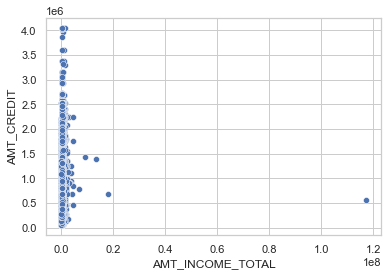

In [108]:
sns.scatterplot(x='AMT_INCOME_TOTAL', y = 'AMT_CREDIT', data=appTrainC)

La quantité de crédit n'a pas l'air d'être corrolé avec les revenus. Au contraire les hauts revenus demandent des crédits faibles.

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='AMT_ANNUITY'>

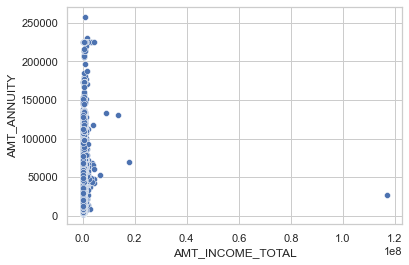

In [109]:
sns.scatterplot(x='AMT_INCOME_TOTAL', y = 'AMT_ANNUITY', data=appTrainC)

Les mensualités n'ont pas l'air d'être corrolé avec les revenus.

<AxesSubplot:xlabel='EXT_SOURCE_2', ylabel='AMT_ANNUITY'>

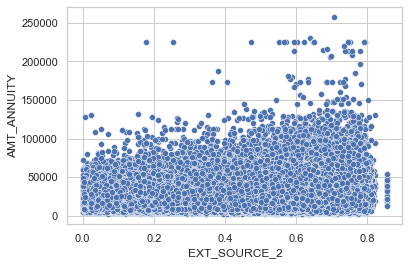

In [110]:
sns.scatterplot(x='EXT_SOURCE_2', y = 'AMT_ANNUITY', data=appTrainC)

<AxesSubplot:xlabel='EXT_SOURCE_3', ylabel='AMT_ANNUITY'>

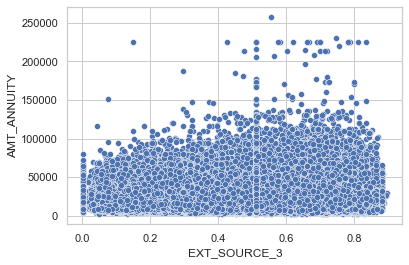

In [111]:
sns.scatterplot(x='EXT_SOURCE_3', y = 'AMT_ANNUITY', data=appTrainC)

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='REGION_POPULATION_RELATIVE'>

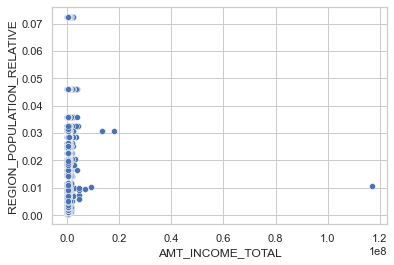

In [112]:
sns.scatterplot(x='AMT_INCOME_TOTAL', y = 'REGION_POPULATION_RELATIVE', data=appTrainC)

# Corrélation

In [113]:
# bureau

In [114]:
# homeCredit

In [115]:
# previous_Apps

In [116]:
correlation = appTrainC.drop(['SK_ID_CURR', 'TARGET'], axis=1)

In [117]:
correlation = correlation.select_dtypes(exclude=['object', 'category', 'int8'])

In [118]:
correlation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307495 entries, 0 to 307510
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AMT_INCOME_TOTAL            307495 non-null  float32
 1   AMT_CREDIT                  307495 non-null  float32
 2   AMT_ANNUITY                 307495 non-null  float32
 3   AMT_GOODS_PRICE             307495 non-null  float32
 4   REGION_POPULATION_RELATIVE  307495 non-null  float16
 5   DAYS_BIRTH                  307495 non-null  int16  
 6   DAYS_EMPLOYED               307495 non-null  float64
 7   DAYS_REGISTRATION           307495 non-null  float16
 8   DAYS_ID_PUBLISH             307495 non-null  int16  
 9   CNT_FAM_MEMBERS             307495 non-null  float16
 10  EXT_SOURCE_2                307495 non-null  float16
 11  EXT_SOURCE_3                307495 non-null  float16
 12  OBS_30_CNT_SOCIAL_CIRCLE    306474 non-null  float16
 13  DEF_30_CNT_SOC

<AxesSubplot:>

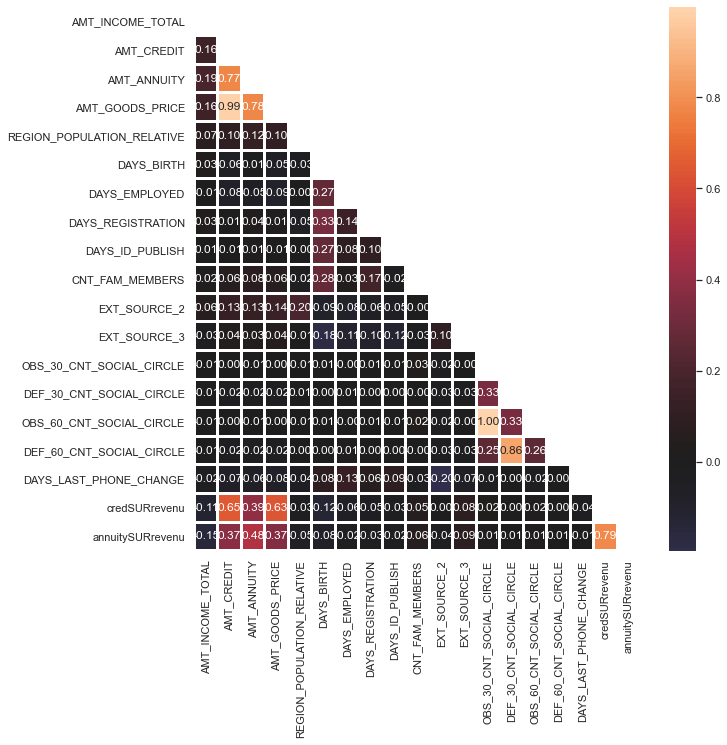

In [119]:
corr = correlation.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10,10))
sns.heatmap(corr, center=0, linewidths=2, mask=mask, annot=True, fmt=".2f")

AMT_GOODS_PRICE et AMT_CREDIT sont très fortement corrolés. Nous supprimerons l'un des deux par la suite.

In [120]:
# deja = []
# for i in corr.index:
#     if i not in list(itertools.chain(*deja)):
#         print(i)
#         print(corr[(np.abs(corr[i]) >=0.8) & (corr[i].index !=i)].index)
#         deja.append(list(corr[(corr[i] >=0.8) & (corr[i].index !=i)].index))
#         #list(itertools.chain(*ls))
   
        


In [121]:
removeCorrelation(corr, 0.8)

['AMT_GOODS_PRICE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']

In [122]:
# print(list(itertools.chain(*deja)))

In [123]:
#appTrainC.to_csv('app/Train.csv', index=False)

In [124]:
appTrainC.drop(removeCorrelation(corr, 0.8), axis=1, inplace=True)

# Modélisation (Classification)

In [125]:
modelisation = appTrainC.drop(['SK_ID_CURR', 'TARGET'], axis=1)

In [126]:
#modelisation

In [127]:
model_num = modelisation.select_dtypes(exclude=['object', 'category'])
model_cat = modelisation.select_dtypes(include=['object', 'category'])

Nous segmentons les données en deux : les features numériques et les features catégorielles

In [128]:
# model_cat

In [129]:
# modelisation.info()

In [130]:
# modelisation['DAYS_EMPLOYED'].min()

In [131]:
model_onhot = pd.get_dummies(model_cat, drop_first=True)

In [132]:
model_onhot.shape

(307495, 88)

Nous encodons les valeurs catégorielles en valeur numérique

In [133]:
model = pd.concat([model_num, model_onhot], axis=1)

In [134]:
model

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,credSURrevenu,annuitySURrevenu,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,0,202500.0,406597.5,24700.5,0.018799,-9461,-637.000000,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,0,0,0,0,0,0,0.262939,0.139404,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.007889,0.121978,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,270000.0

## Pycaret

In [135]:
modelS = pd.concat([model, appTrainC['TARGET']], axis=1)

In [136]:
#modelS

In [137]:
clf1 = setup(data = modelS, target = 'TARGET')

,Description,Value
0,session_id,7338
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307495, 140)"
5,Missing Values,True
6,Numeric Features,139
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
best_model = compare_models(sort = 'AUC')

IntProgress(value=0, description='Processing: ', max=74)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:25:16
Status,. . . . . . . . . . . . . . . . . .,Fitting 3 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Ada Boost Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0860
knn,K Neighbors Classifier,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2290
nb,Naive Bayes,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0840
dt,Decision Tree Classifier,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0830
svm,SVM - Linear Kernel,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1580


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/joblib/parallel.py", line 933, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/concurrent/futures/_base.py", line 434, in result
    self._condition.wait(timeout)
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/joblib/parallel.py", line 1054, in __call__
    self.retrieve()
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/job

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/joblib/parallel.py", line 933, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/concurrent/futures/_base.py", line 434, in result
    self._condition.wait(timeout)
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/joblib/parallel.py", line 1054, in __call__
    self.retrieve()
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/job

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/joblib/parallel.py", line 933, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/concurrent/futures/_base.py", line 434, in result
    self._condition.wait(timeout)
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/joblib/parallel.py", line 1054, in __call__
    self.retrieve()
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/job

Selon les modèles, nous pouvons maximiser différents scores. Mais il n'existe pas un modèle qui maximise le recall et la precision.

In [ ]:
ensembled_models = compare_models(models(type='ensemble').index.tolist(), fold = 3, sort = 'AUC')

INFO:logs:gpu_param set to False
INFO:logs:Initializing compare_models()
INFO:logs:compare_models(include=['rf', 'ada', 'gbc', 'et', 'xgboost', 'lightgbm'], fold=3, round=4, cross_validation=True, sort=AUC, n_select=1, budget_time=None, turbo=True, errors=ignore, fit_kwargs=None, groups=None, verbose=True, display=None, exclude=None)
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor
INFO:logs:Preparing display monitor


IntProgress(value=0, description='Processing: ', max=34)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:25:16
Status,. . . . . . . . . . . . . . . . . .,Fitting 3 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Ada Boost Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)


INFO:logs:Initializing Random Forest Classifier
INFO:logs:Total runtime is 9.051958719889323e-06 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=rf, fold=StratifiedKFold(n_splits=3, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, display=<pycaret.internal.Display.Display object at 0x7f0e3975bb20>, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Random Forest Classifier Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=3, random_state=None, shuffle=False), n_jobs=-1


ERROR! Session/line number was not unique in database. History logging moved to new session 639


  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/joblib/parallel.py", line 933, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/concurrent/futures/_base.py", line 434, in result
    self._condition.wait(timeout)
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/pycaret/internal/tabular.py", line 2166, in compare_models
    model, model_fit_time = create_model_supervised(
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site

INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Ada Boost Classifier Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=3, random_state=None, shuffle=False), n_jobs=-1
Exception ignored in: <function _releaseLock at 0x7f0ef3272160>
Traceback (most recent call last):
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/pycaret/internal/tabular.py", line 2166, in compare_models
    model, model_fit_time = create_model_supervised(
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/pycaret/internal/tabular.py", line 3115, in create_model_supervised
    scores = cross_validat

Traceback (most recent call last):
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/pycaret/internal/tabular.py", line 2166, in compare_models
    model, model_fit_time = create_model_supervised(
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/pycaret/internal/tabular.py", line 3115, in create_model_supervised
    scores = cross_validate(
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 242, in cross_validate
    scores = parallel(
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/joblib/parallel.py", line 1054, in __call__
    self.retrieve()
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/joblib/parallel.py", line 933, in retrieve
    self._output.exten

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/pycaret/internal/tabular.py", line 2166, in compare_models
    model, model_fit_time = create_model_supervised(
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/pycaret/internal/tabular.py", line 3115, in create_model_supervised
    scores = cross_validate(
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 242, in cross_validate
    scores = parallel(
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/joblib/parallel.py", line 1054, in __call__
    self.retrieve()
  File "/home/princeba/anaconda3/envs/ocrprojet7/lib/python3.8/site-packages/joblib/parallel.py", line 933, in retrieve
    self._output.exten

## Recentrons les données

Nous allons réutiliser les mêmes algorithmes mais cette fois sur des données recentrées

In [138]:
# scaler = StandardScaler()
# scaler.fit(model_num)
# model_scale = scaler.transform(model_num)

In [ ]:
# model = pd.concat([pd.DataFrame(model_scale).reset_index(), model_onhot.reset_index()], axis=1)

ERROR! Session/line number was not unique in database. History logging moved to new session 640


KeyboardInterrupt: 

In [ ]:
# model_scale.shape

In [ ]:
# model_onhot.shape

In [ ]:
# model

In [ ]:
# model.drop(['index'], axis=1, inplace=True)

In [ ]:
# model.shape

In [ ]:
# modelS = pd.concat([model, appTrainC['TARGET']], axis=1)

In [ ]:
# clf1 = setup(data = modelS, target = 'TARGET')

In [ ]:
# best_model = compare_models()

## resamplons les datas

In [ ]:
count_nondefault, count_default = modelS['TARGET'].value_counts()

In [ ]:
count_default

In [ ]:
count_nondefault

In [ ]:
nondefaults = modelS[modelS['TARGET'] == 0]
defaults = modelS[modelS['TARGET'] == 1]

In [ ]:
nondefaults_under = nondefaults.sample(count_default)

In [ ]:
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

In [ ]:
clf1 = setup(data = X_y_train_under, target = 'TARGET')

In [ ]:
best_model = compare_models()

In [ ]:
ensembled_models = compare_models(models(type='ensemble').index.tolist(), fold = 10)

L'algorithme __lightgbm__ est un bon compromis entre les scores Accuracy, AUC, Recall, Prec

# Light Gradient Boosting Machine

In [1]:
modelisation = appTrainC.drop(['SK_ID_CURR', 'TARGET'], axis=1)

NameError: name 'appTrainC' is not defined

In [ ]:
model_num = modelisation.select_dtypes(exclude=['object', 'category'])
model_cat = modelisation.select_dtypes(include=['object', 'category'])

In [ ]:
model_onhot = pd.get_dummies(model_cat, drop_first=True)

In [ ]:
model = pd.concat([model_num, model_onhot], axis=1)

In [ ]:
X = model
y = appTrainC['TARGET']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [ ]:
target_names = ['Non-Default', 'Default']

Nous divisons les données en deux. Un training set et test set

In [ ]:
lgbm = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 42)

In [ ]:
clf = lgbm.fit(X_train.to_numpy(), y_train)

In [ ]:
preds = clf.predict(X_test)

In [ ]:
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds, target_names=target_names))

In [ ]:
print(metrics.roc_auc_score(y_test, preds))

# Resamplons les données

In [ ]:
X_y_train = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)

In [ ]:
count_nondefault, count_default = X_y_train['TARGET'].value_counts()

In [ ]:
nondefaults = X_y_train[X_y_train['TARGET'] == 0]
defaults = X_y_train[X_y_train['TARGET'] == 1]

In [ ]:
nondefaults_under = nondefaults.sample(count_default)

In [ ]:
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

In [ ]:
print(X_y_train_under['TARGET'].value_counts())

In [ ]:
X = X_y_train_under.drop('TARGET', axis=1)
y = X_y_train_under['TARGET']

In [ ]:
clfL = lgb.LGBMClassifier(random_state = 42).fit(X.to_numpy(), y)

In [ ]:
preds = clfL.predict(X_test)

In [ ]:
print(classification_report(y_test, preds, target_names=target_names))

Ce qui nous intéresse surtout est de minimiser les faux négatifs. Ces profils coûtent chers à l'entreprise

In [ ]:
#pickle.dump(clfL, open('app/clf.pkl', 'wb'))

In [ ]:
#load_clf = pickle.load(open('app/clf.pkl', 'rb'))

In [ ]:
# preds = load_clf.predict(X_test)
# print(classification_report(y_test, preds, target_names=target_names))

In [ ]:
# preds = load_clf.predict(X_train)
# print(classification_report(y_train, preds, target_names=target_names))

In [ ]:
print(metrics.confusion_matrix(y_test, preds))

In [ ]:
5060/(5060+2388)

In [ ]:
print(metrics.roc_auc_score(y_test, preds))

In [ ]:
preds_df = pd.DataFrame(np.array(pd.concat([pd.DataFrame(clfL.predict_proba(X_test))[1], pd.Series(clfL.predict(X_test)), y_test.reset_index(drop=True), X_test['AMT_CREDIT'].reset_index(drop=True)], axis=1)), columns=["prob_defaut", "PRED_TARGET","TARGET", "AMT_CREDIT"])

In [ ]:
preds_df

In [ ]:
#print(classification_report(preds_df['TARGET'], preds_df['PRED_TARGET'], target_names=target_names))

In [ ]:
fallout_gbt, sensitivity_gbt, thresholds_gbt = metrics.roc_curve(y_test, preds_df["prob_defaut"])

plt.figure(figsize=(15,10))
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'LGBM')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("LGBM")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

# idéal théorique

In [ ]:
thresh = [0.2, 0.225,0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65]

In [ ]:
def_recalls = []
nondef_recalls = []
acc = []

In [ ]:
for i in thresh:
    preds_df['pred_TARGET'] = preds_df['prob_defaut'].apply(lambda x: 1 if x > i else 0)
    acc.append(metrics.accuracy_score(y_test, preds_df['pred_TARGET']))
    def_recalls.append(metrics.precision_recall_fscore_support(y_test,preds_df['pred_TARGET'])[1][1])
    nondef_recalls.append(metrics.precision_recall_fscore_support(y_test,preds_df['pred_TARGET'])[1][0])

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(thresh, def_recalls)
plt.plot(thresh, nondef_recalls)
plt.plot(thresh, acc)
plt.xlabel("seul")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

Ici en un sens le juste milieu entre la capacité du modèle à identifier les vrais défauts, les vrais non-défauts est situé aux alentours d'un seuil de 0.5.<br>
Mais il se peut que du point de vue du métier, ce seuil soit différent.

# Théorie != pratique

Fixons un taux d'acceptation à 85%

In [ ]:
threshold_85 = np.quantile(preds_df["prob_defaut"], 0.85)

# seuil d'acceptation = 0.85
preds_df['pred_TARGET'] = preds_df["prob_defaut"].apply(lambda x: 1 if x > threshold_85 else 0)

# Print the counts of loan status after the threshold
print(preds_df['pred_TARGET'].value_counts())

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(preds_df["prob_defaut"], color = 'blue', bins = 40)

plt.axvline(x = threshold_85, color = 'red')
plt.show()

In [ ]:
np.sum(preds_df['TARGET'])

In [ ]:
accepted_loans = preds_df[preds_df['pred_TARGET'] == 0]

In [ ]:
print(np.sum(accepted_loans['TARGET']) / accepted_loans['TARGET'].count())

Parmi les profils acceptés avec un taux d'acceptation de 85%. Nous aurons 5% de faux négatifs

## Le coût

In [ ]:
avg_loan = np.mean(preds_df['AMT_CREDIT'])

In [ ]:
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(preds_df['TARGET'],
                 preds_df['pred_TARGET']).apply(lambda x: x * avg_loan, axis = 0))
pd.reset_option('^display.', silent=True)

Les prévisions de notre modèle permettent de gagner 44 milliards, les FN causent une perte de 2.6 milliards, les FP causent une perte de 6,4 milliards qui est à relativiser dans la mesure où les pertes dûes à un faux positifs relèvent davantage (d'un certain point de vue) des coûts horaires du chargé de clientèle.

# Seuil 0.5

In [ ]:
threshold = np.quantile(preds_df["prob_defaut"], 0.5)

# seuil d'acceptation = 0.85
preds_df['pred_TARGET'] = preds_df["prob_defaut"].apply(lambda x: 1 if x > 0.5 else 0)

# Print the counts of loan status after the threshold
print(preds_df['pred_TARGET'].value_counts())

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(preds_df["prob_defaut"], color = 'blue', bins = 40)

plt.axvline(x = threshold, color = 'red')
plt.show()

In [ ]:
accepted_loans = preds_df[preds_df['pred_TARGET'] == 0]

In [ ]:
print(np.sum(accepted_loans['TARGET']) / accepted_loans['TARGET'].count())

In [ ]:
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(preds_df['TARGET'],
                 preds_df['pred_TARGET']).apply(lambda x: x * avg_loan, axis = 0))
pd.reset_option('^display.', silent=True)

On peut voir que le taux théorique produit des profits inférieurs à celui que nous avons fixé par hasard, soit le taux de 85%

# Recherche d'un seuil pour un profit maximal

In [ ]:
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 
                0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

Définissons différent taux d'acceptation.

In [ ]:
thresholds = []
bad_rates = []
for rate in accept_rates:
    
    thresh = np.quantile(preds_df['prob_defaut'], rate).round(3)
    
    thresholds.append(np.quantile(preds_df['prob_defaut'], rate).round(3))
    
    preds_df['pred_TARGET'] = preds_df['prob_defaut'].apply(lambda x: 1 if x > thresh else 0)
    
    accepted_loans = preds_df[preds_df['pred_TARGET'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['TARGET']) / len(accepted_loans['TARGET'])).round(3))

In [ ]:
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Taux acceptation','Threshold','Bad Rate'])

In [ ]:
strat_df.boxplot()
plt.show()

In [ ]:
plt.plot(strat_df['Taux acceptation'], strat_df['Bad Rate'])
plt.xlabel('Taux acceptation')
plt.ylabel('Bad Rate')
plt.title('Acceptation et mauvais taux')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [ ]:
strat_df['Avg'] = avg_loan

In [ ]:
nb_accept = []
for rate in accept_rates:
    
    thresh = np.quantile(preds_df['prob_defaut'], rate).round(3)
    
    nb_accept.append(np.sum(preds_df["prob_defaut"] < thresh))
    

In [ ]:
strat_df['nb_accept'] = nb_accept

In [ ]:
strat_df

In [ ]:
strat_df['estimation'] = strat_df['nb_accept']*(1-strat_df['Bad Rate'])*strat_df['Avg'] - strat_df['nb_accept']*strat_df['Bad Rate']*strat_df['Avg']

In [ ]:
strat_df

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(strat_df['Taux acceptation'], strat_df['estimation'])
plt.title('')
plt.xlabel('Taux acceptation')
plt.ylabel('Estimation')
plt.axes().yaxis.grid()
plt.show()

Le dataset ne contient que 8% de profil en défaut. De là, il est normal notre modélisation préconise un taux d'acceptation de 100. Dans tous les cas, nous sommes gagnons.

# Resamplons les données de test

Nous reproduisons le raisonnement précédent mais cette fois en étant moins optimiste vis à vis

In [ ]:
X_y_test = pd.concat([X_test.reset_index(drop = True), y_test.reset_index(drop = True)], axis = 1)

In [ ]:
X_y_test

In [ ]:
count_nondefault, count_default = X_y_test['TARGET'].value_counts()

In [ ]:
nondefaults = X_y_test[X_y_test['TARGET'] == 0]
defaults = X_y_test[X_y_test['TARGET'] == 1]

In [ ]:
nondefaults_under = nondefaults.sample(3*count_default, random_state=42)

In [ ]:
X_y_test_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

In [ ]:
X_test_U = X_y_test_under.drop('TARGET', axis=1)
y_test_U = X_y_test_under['TARGET']

In [ ]:
preds = clfL.predict(X_test_U)

In [ ]:
print(classification_report(y_test_U, preds, target_names=target_names))

In [ ]:
print(metrics.confusion_matrix(y_test_U, preds))

In [ ]:
preds_df = pd.DataFrame(np.array(pd.concat([pd.DataFrame(clfL.predict_proba(X_test_U))[1], pd.Series(clfL.predict(X_test_U)), y_test_U.reset_index(drop=True), X_test_U['AMT_CREDIT'].reset_index(drop=True)], axis=1)), columns=["prob_defaut", "PRED_TARGET","TARGET", "AMT_CREDIT"])

In [ ]:
preds_df

In [ ]:
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 
                0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

In [ ]:
thresholds = []
bad_rates = []
for rate in accept_rates:
    
    thresh = np.quantile(preds_df['prob_defaut'], rate).round(3)
    
    thresholds.append(np.quantile(preds_df['prob_defaut'], rate).round(3))
    
    preds_df['pred_TARGET'] = preds_df['prob_defaut'].apply(lambda x: 1 if x > thresh else 0)
    
    accepted_loans = preds_df[preds_df['pred_TARGET'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['TARGET']) / len(accepted_loans['TARGET'])).round(3))

In [ ]:
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Taux acceptation','Threshold','Bad Rate'])

In [ ]:
strat_df

In [ ]:
plt.plot(strat_df['Taux acceptation'], strat_df['Bad Rate'])
plt.xlabel('Taux acceptation')
plt.ylabel('Bad Rate')
plt.title('Acceptation et mauvais taux')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [ ]:
strat_df['Avg'] = X_test_U["AMT_CREDIT"].mean()

In [ ]:
strat_df['Avg'] 

In [ ]:
nb_accept = []
for rate in accept_rates:
    
    thresh = np.quantile(preds_df['prob_defaut'], rate).round(3)
    
    nb_accept.append(np.sum(preds_df["prob_defaut"] < thresh))

In [ ]:
strat_df['nb_accept'] = nb_accept

In [ ]:
strat_df

In [ ]:
strat_df['estimation'] = strat_df['nb_accept']*(1-strat_df['Bad Rate'])*strat_df['Avg'] - strat_df['nb_accept']*strat_df['Bad Rate']*strat_df['Avg']

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(strat_df['Taux acceptation'], strat_df['estimation'])
plt.title('')
plt.xlabel('Taux acceptation')
plt.ylabel('Estimation')
plt.axes().yaxis.grid()
plt.show()

In [ ]:
print(strat_df.loc[strat_df['estimation'] == np.max(strat_df['estimation'])])

Nous avons resamplé le dataset de sorte d'obtenir 25% de défauts dans le dataset. <br>
Dans ce cas, nous fixons le seuil de probabilité de défaut de paiement à 0.752

In [ ]:
preds_df['expected_loss'] = preds_df['prob_defaut'] * preds_df['AMT_CREDIT'] 

In [ ]:
tot_exp_loss = round(np.sum(preds_df['expected_loss']),2)

In [ ]:
print('Le total des pertes attendues: ', '${:,.2f}'.format(tot_exp_loss))

In [ ]:
preds_df['pred_TARGET'] = preds_df['prob_defaut'].apply(lambda x: 1 if x > 0.752 else 0)
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(preds_df['TARGET'],
                 preds_df['pred_TARGET']).apply(lambda x: x * avg_loan, axis = 0))
pd.reset_option('^display.', silent=True)

In [ ]:
#%reset -f